# Load data and preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df = pd.read_csv(r"C:\Users\leege\Documents\Govtech\Assesment\CEASalespersonsPropertyTransactionRecordsresidential.csv")
df_prices = pd.read_csv(r"C:\Users\leege\Documents\Govtech\Assesment\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")


In [2]:
# Convert data and filter
df["transaction_date"] = pd.to_datetime(df["transaction_date"], format="%b-%Y", errors="coerce")
df_prices["month"] = pd.to_datetime(df_prices["month"], format="%Y-%m")
df = df[df["transaction_date"].dt.year >= 2017].copy()

# Set pre or post policy
cutoff = pd.Timestamp("2018-01-01")
df["period"] = df["transaction_date"].apply(lambda x: "Pre" if x < cutoff else "Post")

# Prepare df
df_hdb = df[(df["property_type"] == "HDB") & (df["transaction_type"] == "RESALE")].copy()
df_hdb["year"] = df_hdb["transaction_date"].dt.year
df_hdb["month_num"] = df_hdb["transaction_date"].dt.month
monthly_counts_df = df_hdb.groupby(["year", "month_num"]).size().reset_index(name="total_transac_from_agents")

# Prepare df_prices
df_prices["year"] = df_prices["month"].dt.year
df_prices["month_num"] = df_prices["month"].dt.month
monthly_counts_prices = df_prices.groupby(["year", "month_num"]).size().reset_index(name="count_prices")
monthly_counts_prices = monthly_counts_prices.rename(columns={'count_prices': 'hdb_sold'})
monthly_counts_prices["total_transac_from_hdbs"] = monthly_counts_prices["hdb_sold"] * 2

# Merge the two monthly summaries
monthly_combined = monthly_counts_df.merge(
    monthly_counts_prices,
    on=["year", "month_num"],
    how="outer"
).fillna(0)  # fill missing months with 0 if a month is missing in either dataset

monthly_combined['agentsToHDBs'] = monthly_combined['total_transac_from_agents'] / monthly_combined['hdb_sold']

monthly_combined['agentsToHDBs_MA3'] = (
    monthly_combined['total_transac_from_agents'].rolling(3, min_periods=1).mean() /
    monthly_combined['hdb_sold'].rolling(3, min_periods=1).mean()
)

monthly_agents = (
    df_hdb.groupby(["year", "month_num"])["salesperson_reg_num"]
    .nunique()
    .reset_index(name="unique_agents")
)

monthly_combined = monthly_combined.merge(
    monthly_agents,
    on=["year", "month_num"],
    how="left"
).fillna(0)

monthly_combined["avg_cases_per_agent"] = (
    monthly_combined["total_transac_from_agents"] / monthly_combined["unique_agents"]
)


monthly_combined.head(5)

,year,month_num,total_transac_from_agents,hdb_sold,total_transac_from_hdbs,agentsToHDBs,agentsToHDBs_MA3,unique_agents,avg_cases_per_agent
0,2017,1,2453,1185,2370,2.070042,2.070042,1789,1.371157
1,2017,2,2596,1085,2170,2.392627,2.224229,1845,1.407046
2,2017,3,2310,1903,3806,1.213873,1.763480,1662,1.389892
3,2017,4,2468,1839,3678,1.342034,1.527657,1786,1.381859
4,2017,5,2713,1980,3960,1.370202,1.309158,1894,1.432418


In [3]:
monthly_role_counts = (
    df_hdb.groupby(["year", "month_num", "represented"])
    .size()
    .unstack(fill_value=0)   # Creates separate columns for BUYER and SELLER
    .reset_index()
)

# Ensure both columns exist even if a month has zero for a role
for col in ["BUYER", "SELLER"]:
    if col not in monthly_role_counts.columns:
        monthly_role_counts[col] = 0

# --- Average resale price per month ---
monthly_avg_price = (
    df_prices.groupby(["year", "month_num"])["resale_price"]
    .median()
    .reset_index(name="avg_price")
)

monthly_total_price = (
    df_prices.groupby(["year", "month_num"])["resale_price"]
    .sum()
    .reset_index(name="total_sales_price")
) 

monthly_summary = monthly_role_counts.merge(
    monthly_avg_price,
    on=["year", "month_num"],
    how="left"
).fillna(0)

monthly_summary = monthly_summary.merge(
    monthly_total_price,
    on=["year", "month_num"],
    how="left"
).fillna(0)

monthly_agents = (
    df_hdb.groupby(["year", "month_num"])["salesperson_reg_num"]
    .nunique()
    .reset_index(name="unique_agents")
)

monthly_summary = monthly_summary.merge(
    monthly_agents,
    on=["year", "month_num"],
    how="left"
).fillna(0)

# --- Estimate agent revenue ---
monthly_summary["seller_revenue"] = monthly_summary["SELLER"] * monthly_summary["avg_price"] * 0.02
monthly_summary["buyer_revenue"] = monthly_summary["BUYER"] * monthly_summary["avg_price"] * 0.01
monthly_summary["total_agent_revenue"] = monthly_summary["seller_revenue"] + monthly_summary["buyer_revenue"]
monthly_summary["avg_agent_revenue"] = monthly_summary["total_agent_revenue"] / monthly_summary["unique_agents"]
monthly_summary = monthly_summary.drop(columns=["unique_agents"])

monthly_summary = monthly_summary.merge(
    monthly_combined,
    on=["year", "month_num"],
    how="inner"
)

monthly_summary['date'] = pd.to_datetime({
    'year': monthly_summary['year'],
    'month': monthly_summary['month_num'],  # must be named 'month'
    'day': 1
})


monthly_summary.head(5)

,year,month_num,BUYER,SELLER,avg_price,total_sales_price,seller_revenue,buyer_revenue,total_agent_revenue,avg_agent_revenue,total_transac_from_agents,hdb_sold,total_transac_from_hdbs,agentsToHDBs,agentsToHDBs_MA3,unique_agents,avg_cases_per_agent,date
0,2017,1,1053,1400,405000.0,5.065958e+08,11340000.0,4264650.0,15604650.0,8722.554500,2453,1185,2370,2.070042,2.070042,1789,1.371157,2017-01-01
1,2017,2,1086,1510,415000.0,4.854276e+08,12533000.0,4506900.0,17039900.0,9235.718157,2596,1085,2170,2.392627,2.224229,1845,1.407046,2017-02-01
2,2017,3,935,1375,415000.0,8.468919e+08,11412500.0,3880250.0,15292750.0,9201.413959,2310,1903,3806,1.213873,1.763480,1662,1.389892,2017-03-01
3,2017,4,1003,1465,408000.0,8.066392e+08,11954400.0,4092240.0,16046640.0,8984.680851,2468,1839,3678,1.342034,1.527657,1786,1.381859,2017-04-01
4,2017,5,1096,1617,410000.0,8.787029e+08,13259400.0,4493600.0,17753000.0,9373.284055,2713,1980,3960,1.370202,1.309158,1894,1.432418,2017-05-01


In [4]:
# Suspicious dups, unable to delete due to lack of info
dups = df_hdb[df_hdb.duplicated(
    subset=['salesperson_reg_num', 'transaction_date', 'represented', 'town'], keep=False
)]

# Agent Activity

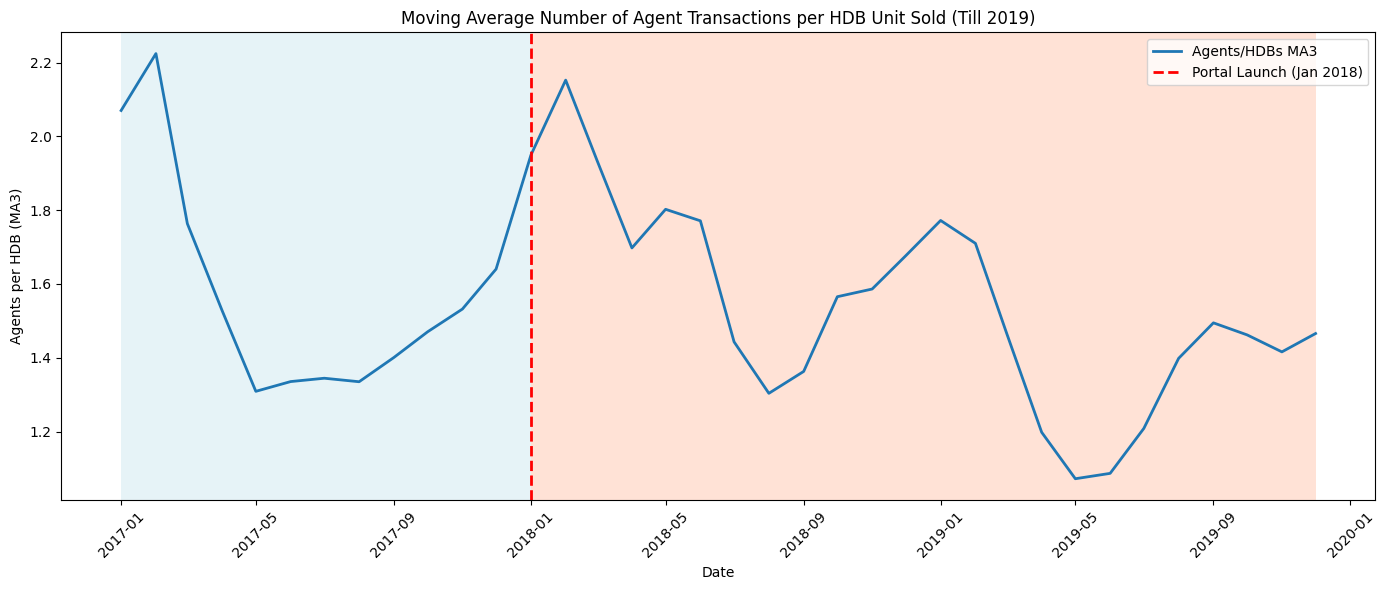

In [5]:
import matplotlib.pyplot as plt

monthly_summary['date'] = pd.to_datetime({
    'year': monthly_summary['year'],
    'month': monthly_summary['month_num'],
    'day': 1
})
monthly_summary = monthly_summary.sort_values('date')

# Filter to max 2019-12
df_plot = monthly_summary[monthly_summary['date'] <= '2019-12-31']

portal_launch = pd.to_datetime('2018-01-01')

plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['agentsToHDBs_MA3'], color='tab:blue', linewidth=2, label='Agents/HDBs MA3')

# Shade regions: light blue before, light orange after
plt.axvspan(df_plot['date'].min(), portal_launch, facecolor='lightblue', alpha=0.3)
plt.axvspan(portal_launch, df_plot['date'].max(), facecolor='lightsalmon', alpha=0.3)

# Portal launch line
plt.axvline(portal_launch, color='red', linestyle='--', linewidth=2, label='Portal Launch (Jan 2018)')

plt.title('Moving Average Number of Agent Transactions per HDB Unit Sold (Till 2019)')
plt.xlabel('Date')
plt.ylabel('Agents per HDB (MA3)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


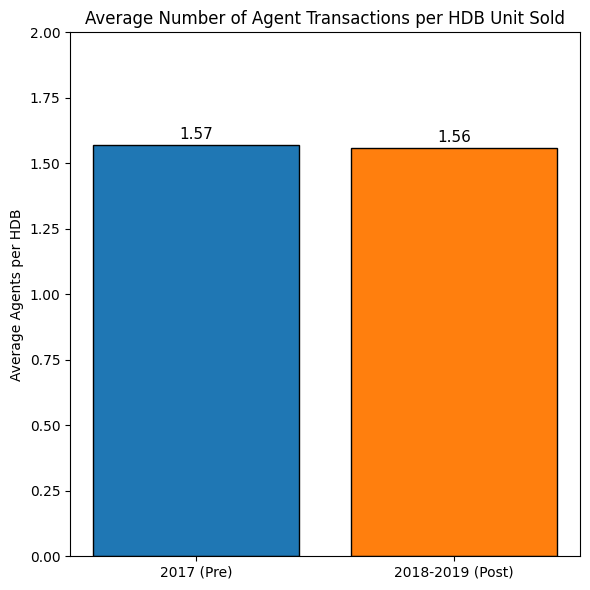

In [6]:
import matplotlib.pyplot as plt

df_bar = monthly_summary[monthly_summary['year'].isin([2017, 2018, 2019])]
avg_2017 = df_bar[df_bar['year'] == 2017]['agentsToHDBs'].mean()
avg_2018_2019 = df_bar[df_bar['year'].isin([2018, 2019])]['agentsToHDBs'].mean()

labels = ['2017 (Pre)', '2018-2019 (Post)']
values = [round(avg_2017, 2), round(avg_2018_2019, 2)]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(6,6))
bars = plt.bar(labels, values, color=colors, edgecolor='black', width=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=11)

plt.ylabel('Average Agents per HDB')
plt.title('Average Number of Agent Transactions per HDB Unit Sold')
plt.ylim(0, 2)
plt.tight_layout()
plt.show()


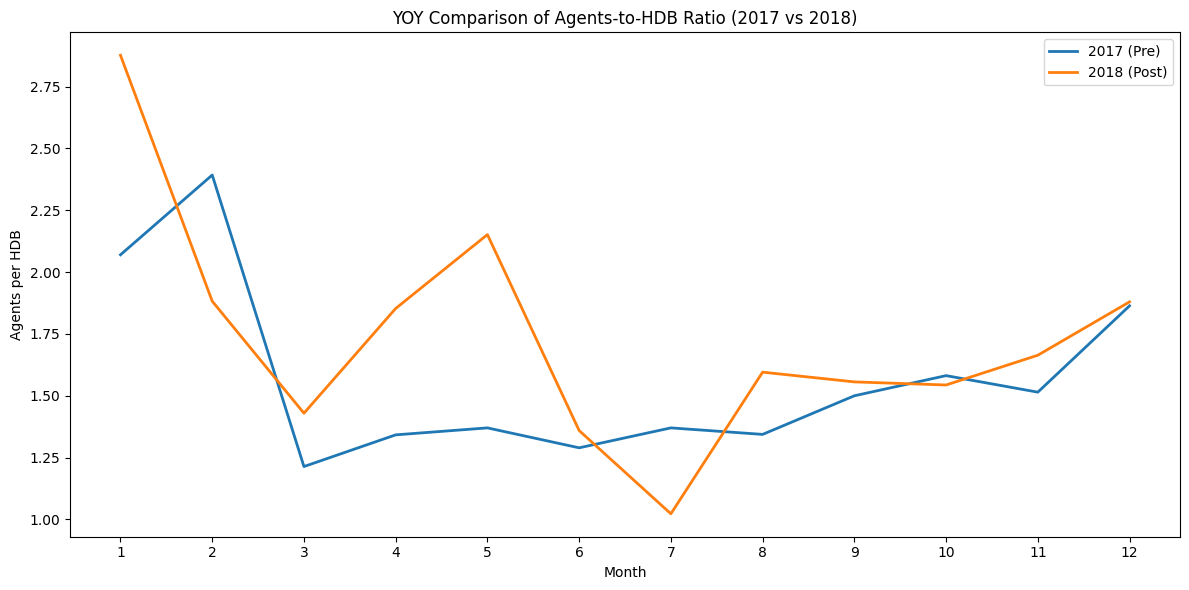

In [7]:
import matplotlib.pyplot as plt

df_yoy = monthly_summary[monthly_summary['year'].isin([2017, 2018])]

plt.figure(figsize=(12,6))
plt.plot(df_yoy[df_yoy['year']==2017]['month_num'], df_yoy[df_yoy['year']==2017]['agentsToHDBs'], color='#1f77b4', linewidth=2, label='2017 (Pre)')
plt.plot(df_yoy[df_yoy['year']==2018]['month_num'], df_yoy[df_yoy['year']==2018]['agentsToHDBs'], color='#ff7f0e', linewidth=2, label='2018 (Post)')
plt.title('YOY Comparison of Agents-to-HDB Ratio (2017 vs 2018)')
plt.xlabel('Month')
plt.ylabel('Agents per HDB')
plt.xticks(range(1,13))
plt.legend()
plt.tight_layout()
plt.show()


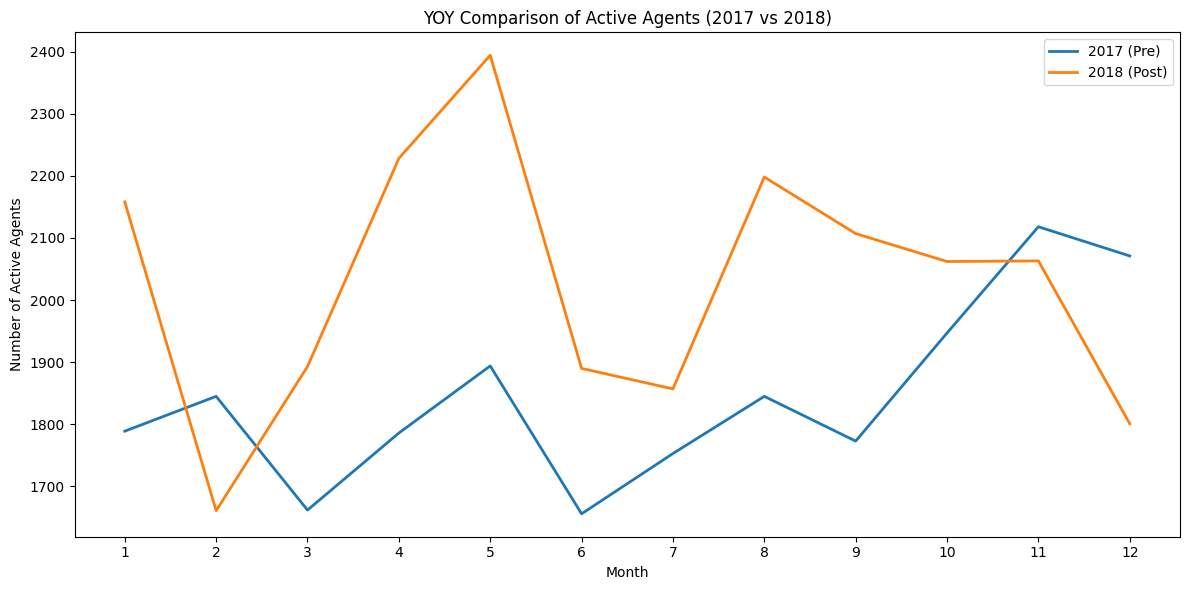

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df_yoy[df_yoy['year']==2017]['month_num'], df_yoy[df_yoy['year']==2017]['unique_agents'], color='#1f77b4', linewidth=2, label='2017 (Pre)')
plt.plot(df_yoy[df_yoy['year']==2018]['month_num'], df_yoy[df_yoy['year']==2018]['unique_agents'], color='#ff7f0e', linewidth=2, label='2018 (Post)')
plt.title('YOY Comparison of Active Agents (2017 vs 2018)')
plt.xlabel('Month')
plt.ylabel('Number of Active Agents')
plt.xticks(range(1,13))
plt.legend()
plt.tight_layout()
plt.show()


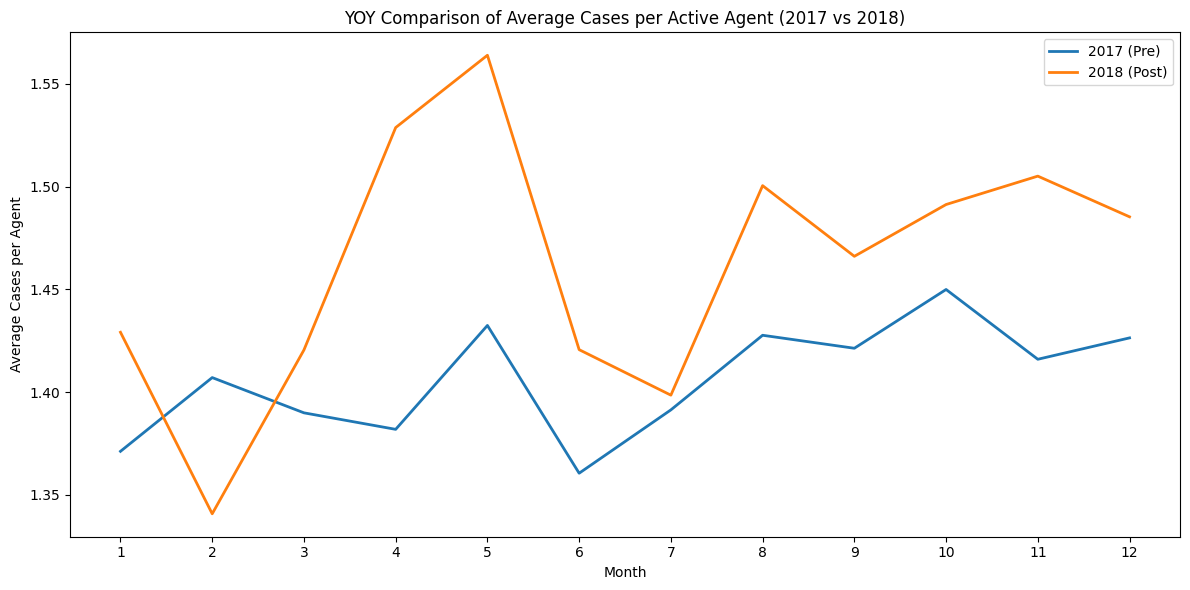

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df_yoy[df_yoy['year']==2017]['month_num'], df_yoy[df_yoy['year']==2017]['avg_cases_per_agent'], color='#1f77b4', linewidth=2, label='2017 (Pre)')
plt.plot(df_yoy[df_yoy['year']==2018]['month_num'], df_yoy[df_yoy['year']==2018]['avg_cases_per_agent'], color='#ff7f0e', linewidth=2, label='2018 (Post)')
plt.title('YOY Comparison of Average Cases per Active Agent (2017 vs 2018)')
plt.xlabel('Month')
plt.ylabel('Average Cases per Agent')
plt.xticks(range(1,13))
plt.legend()
plt.tight_layout()
plt.show()


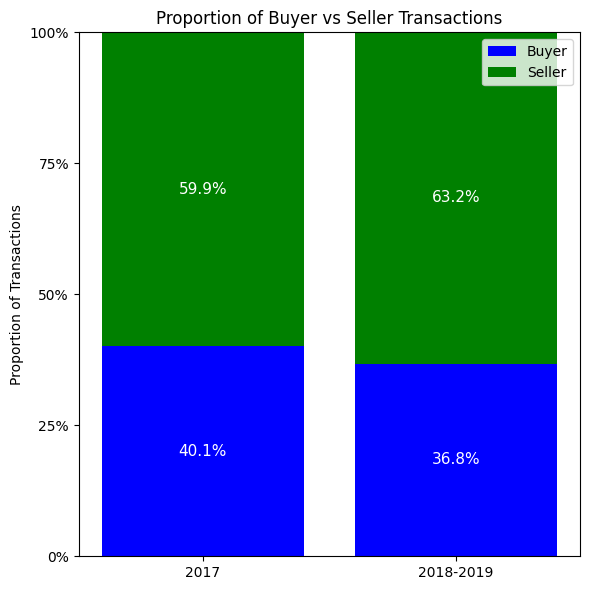

In [10]:
import numpy as np

df_bar = monthly_summary[monthly_summary['year'].isin([2017, 2018, 2019])]
buyer_2017 = df_bar[df_bar['year']==2017]['BUYER'].sum()
seller_2017 = df_bar[df_bar['year']==2017]['SELLER'].sum()
buyer_2018_19 = df_bar[df_bar['year'].isin([2018, 2019])]['BUYER'].sum()
seller_2018_19 = df_bar[df_bar['year'].isin([2018, 2019])]['SELLER'].sum()

labels = ['2017', '2018-2019']
buyer_vals = [buyer_2017, buyer_2018_19]
seller_vals = [seller_2017, seller_2018_19]

total_vals = np.array(buyer_vals) + np.array(seller_vals)
buyer_props = np.array(buyer_vals) / total_vals
seller_props = np.array(seller_vals) / total_vals

width = 0.8
ind = np.arange(len(labels))

plt.figure(figsize=(6,6))
p1 = plt.bar(ind, buyer_props, width, color='blue', label='Buyer')
p2 = plt.bar(ind, seller_props, width, bottom=buyer_props, color='green', label='Seller')

for i in range(len(labels)):
    plt.text(ind[i], buyer_props[i]/2, f'{buyer_props[i]*100:.1f}%', ha='center', va='center', color='white', fontsize=11)
    plt.text(ind[i], buyer_props[i]+seller_props[i]/2, f'{seller_props[i]*100:.1f}%', ha='center', va='center', color='white', fontsize=11)

plt.xticks(ind, labels)
plt.ylabel('Proportion of Transactions')
plt.title('Proportion of Buyer vs Seller Transactions')
plt.ylim(0,1)
plt.yticks([0,0.25,0.5,0.75,1], ['0%','25%','50%','75%','100%'])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Agent Revenue

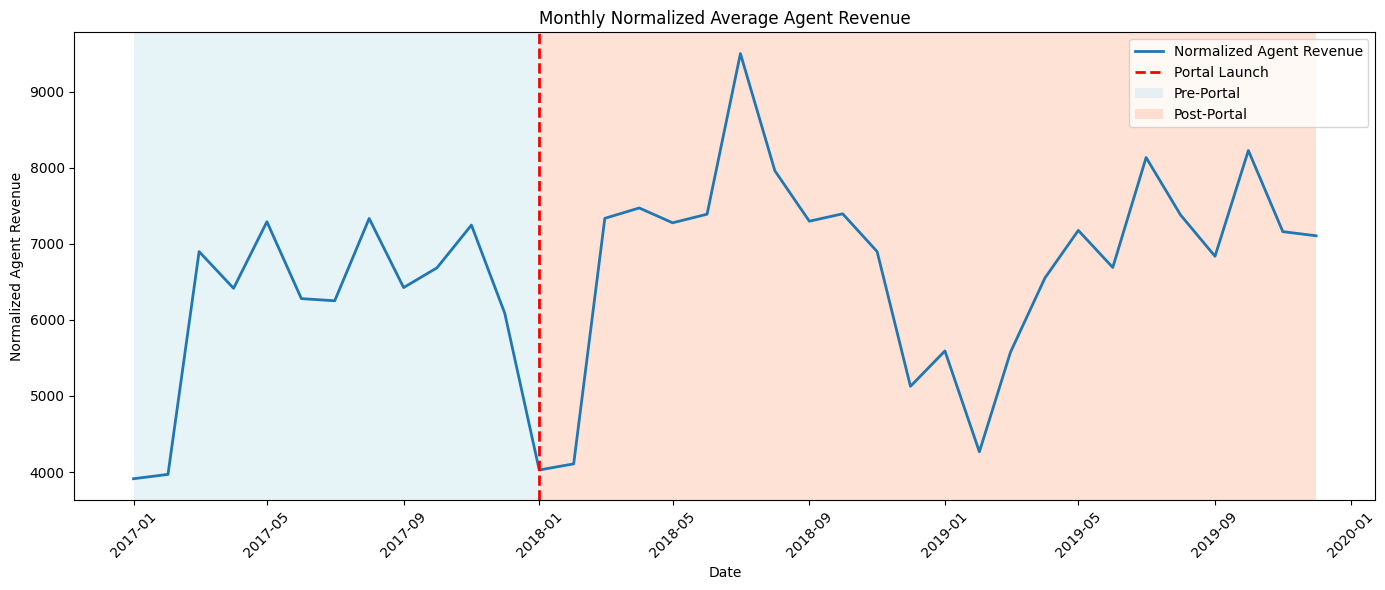

In [11]:
df_plot = monthly_summary[monthly_summary['date'] <= '2019-12-31'].copy()
df_plot['norm_factor'] = df_plot['total_sales_price'] / df_plot['total_sales_price'].max()
df_plot['normalized_agent_revenue'] = df_plot['avg_agent_revenue'] * df_plot['norm_factor']
portal_launch = pd.to_datetime('2018-01-01')

plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['normalized_agent_revenue'], color='tab:blue', linewidth=2, label='Normalized Agent Revenue')
plt.axvline(portal_launch, color='red', linestyle='--', linewidth=2, label='Portal Launch')
plt.axvspan(df_plot['date'].min(), portal_launch, facecolor='lightblue', alpha=0.3, label='Pre-Portal')
plt.axvspan(portal_launch, df_plot['date'].max(), facecolor='lightsalmon', alpha=0.3, label='Post-Portal')
plt.title('Monthly Normalized Average Agent Revenue')
plt.xlabel('Date')
plt.ylabel('Normalized Agent Revenue')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


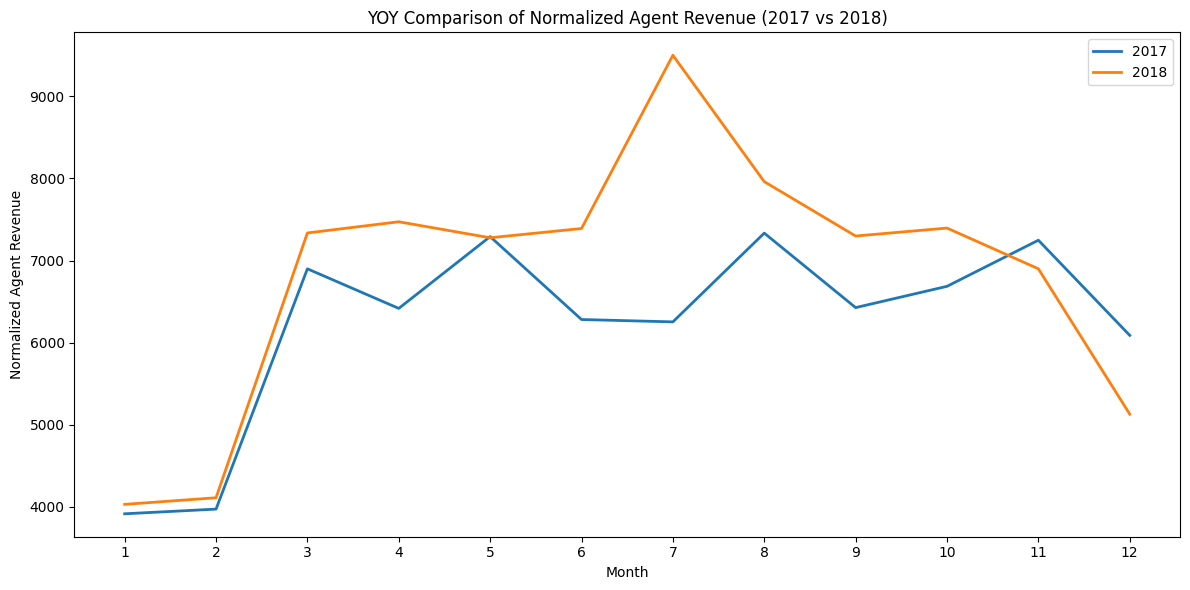

In [12]:
df_yoy = monthly_summary[monthly_summary['year'].isin([2017, 2018])].copy()
df_yoy['norm_factor'] = df_yoy['total_sales_price'] / df_yoy['total_sales_price'].max()
df_yoy['normalized_agent_revenue'] = df_yoy['avg_agent_revenue'] * df_yoy['norm_factor']

plt.figure(figsize=(12,6))
plt.plot(df_yoy[df_yoy['year']==2017]['month_num'], df_yoy[df_yoy['year']==2017]['normalized_agent_revenue'], color='#1f77b4', linewidth=2, label='2017')
plt.plot(df_yoy[df_yoy['year']==2018]['month_num'], df_yoy[df_yoy['year']==2018]['normalized_agent_revenue'], color='#ff7f0e', linewidth=2, label='2018')
plt.title('YOY Comparison of Normalized Agent Revenue (2017 vs 2018)')
plt.xlabel('Month')
plt.ylabel('Normalized Agent Revenue')
plt.xticks(range(1,13))
plt.legend()
plt.tight_layout()
plt.show()


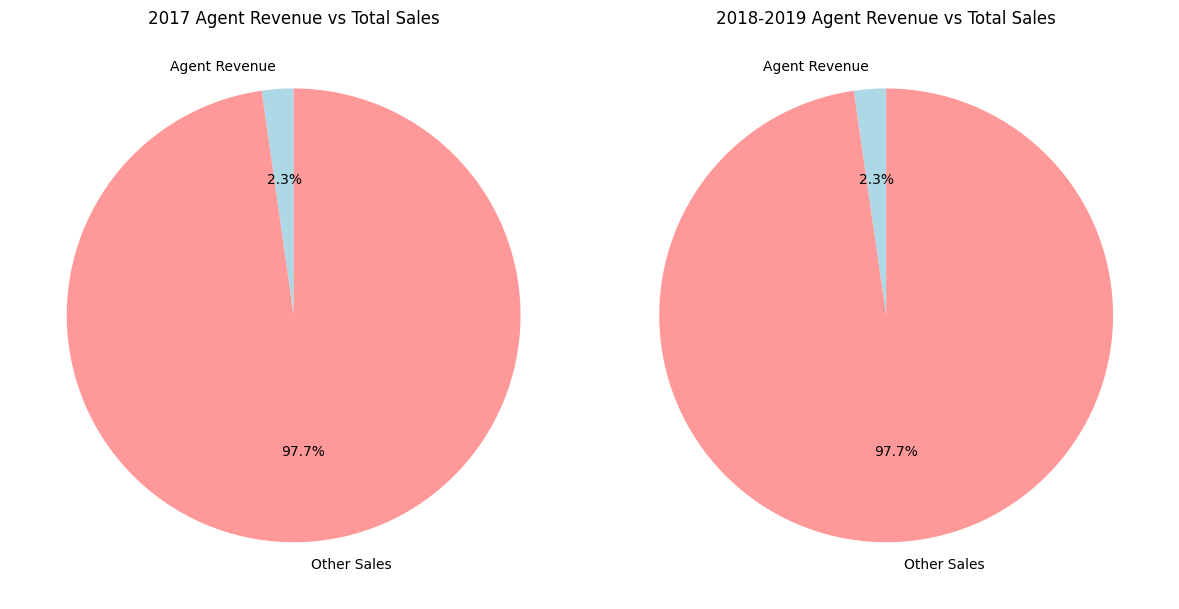

In [13]:
import matplotlib.pyplot as plt

# Filter relevant years
df_bar = monthly_summary[monthly_summary['year'].isin([2017, 2018, 2019])]

rev_2017 = df_bar[df_bar['year']==2017]['total_agent_revenue'].sum()
sales_2017 = df_bar[df_bar['year']==2017]['total_sales_price'].sum()

rev_2018_19 = df_bar[df_bar['year'].isin([2018, 2019])]['total_agent_revenue'].sum()
sales_2018_19 = df_bar[df_bar['year'].isin([2018, 2019])]['total_sales_price'].sum()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.pie(
    [rev_2017, sales_2017-rev_2017],
    labels=['Agent Revenue', 'Other Sales'],
    autopct='%1.1f%%',
    colors=['lightblue','#ff9999'],
    startangle=90
)
plt.title('2017 Agent Revenue vs Total Sales')

plt.subplot(1,2,2)
plt.pie(
    [rev_2018_19, sales_2018_19-rev_2018_19],
    labels=['Agent Revenue', 'Other Sales'],
    autopct='%1.1f%%',
    colors=['lightblue','#ff9999'],
    startangle=90
)
plt.title('2018-2019 Agent Revenue vs Total Sales')

plt.tight_layout()
plt.show()


# Other charts - By location, lease dates etc

In [14]:
town_to_region = {
    "ANG MO KIO": "North",
    "YISHUN": "North",
    "SEMBAWANG": "North",
    "WOODLANDS": "North",
    "CHOA CHU KANG": "West",
    "BUKIT PANJANG": "West",
    "JURONG EAST": "West",
    "JURONG WEST": "West",
    "TENGAH": "West",
    "CLEMENTI": "West",
    "TOA PAYOH": "Central",
    "QUEENSTOWN": "Central",
    "TANGLIN": "Central",
    "KALLANG/WHAMPOA": "Central",
    "BEDOK": "East",
    "TAMPINES": "East",
    "PASIR RIS": "East",
    "PUNGGOL": "East",
    "SENGKANG": "East",
    "MARINE PARADE": "East",
    "BISHAN": "Central",
    "HOUGANG": "North-East",
    "SERANGOON": "North-East",
    "GEYLANG": "East",
    "NOVENA": "Central",
    "BUKIT MERAH": "Central",
    "BUKIT BATOK": "West",
    "CENTRAL AREA": "Central",
    "BUKIT TIMAH": "West"
}

df["region_from_town"] = df["town"].map(town_to_region)


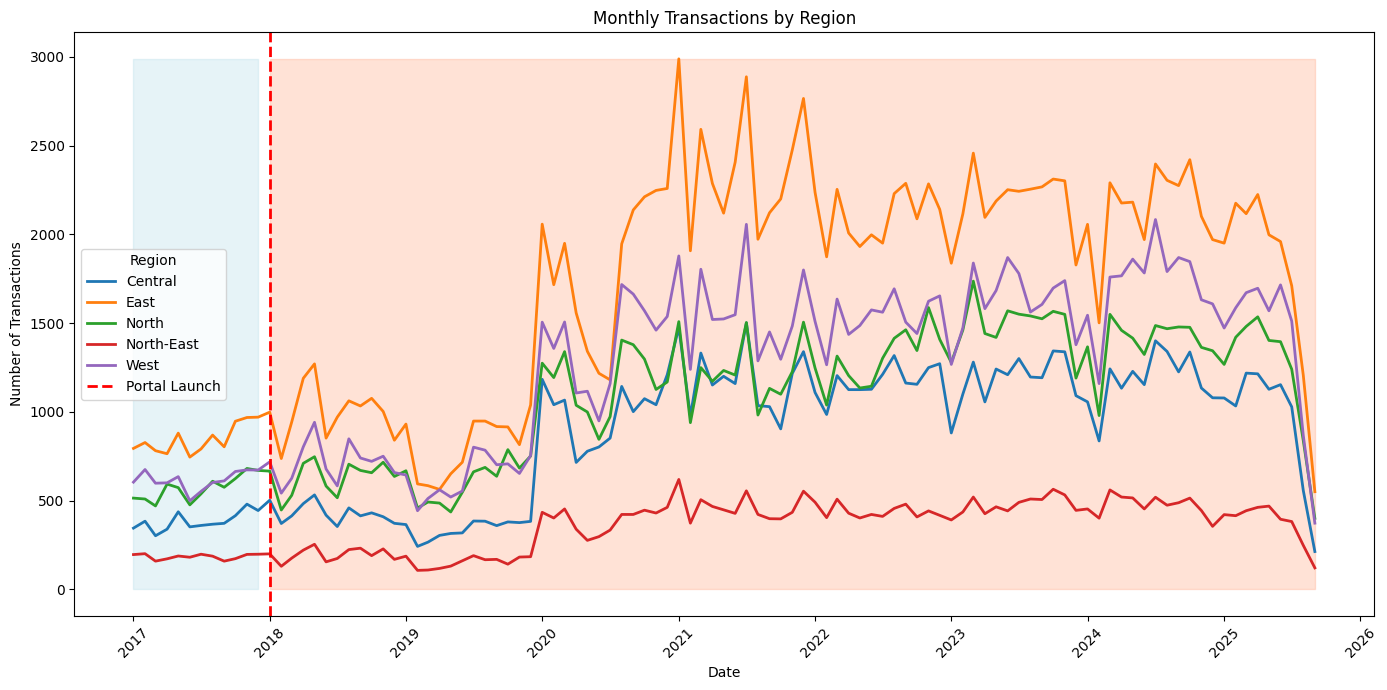

In [15]:
import matplotlib.pyplot as plt

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df_region = df[df['region_from_town'].notna()]

monthly_region = df_region.groupby([df_region['transaction_date'].dt.to_period('M'), 'region_from_town']).size().unstack(fill_value=0)
monthly_region.index = monthly_region.index.to_timestamp()

plt.figure(figsize=(14,7))
for region in monthly_region.columns:
    plt.plot(monthly_region.index, monthly_region[region], linewidth=2, label=region)

portal_launch = pd.to_datetime('2018-01-01')
plt.axvline(portal_launch, color='red', linestyle='--', linewidth=2, label='Portal Launch')

plt.fill_between(monthly_region.index, 0, monthly_region.max().max(), where=monthly_region.index<portal_launch, color='lightblue', alpha=0.3)
plt.fill_between(monthly_region.index, 0, monthly_region.max().max(), where=monthly_region.index>=portal_launch, color='lightsalmon', alpha=0.3)

plt.title('Monthly Transactions by Region')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()
plt.show()


In [18]:
def lease_to_years(lease_str):
    if pd.isna(lease_str):
        return np.nan
    match = re.match(r"(\d+)\s+years\s+(\d+)\s+months?", lease_str)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + months / 12
    return np.nan

df_prices["remaining_lease_years"] = df_prices["remaining_lease"].apply(lease_to_years)

# --- Bucket remaining lease ---
def lease_bucket(years):
    if pd.isna(years):
        return np.nan
    elif years < 30:
        return "Very Old"
    elif years <= 75:
        return "Older"
    elif years <= 90:
        return "Moderate"
    else:
        return "New"

df_prices["lease_bucket"] = df_prices["remaining_lease_years"].apply(lease_bucket)


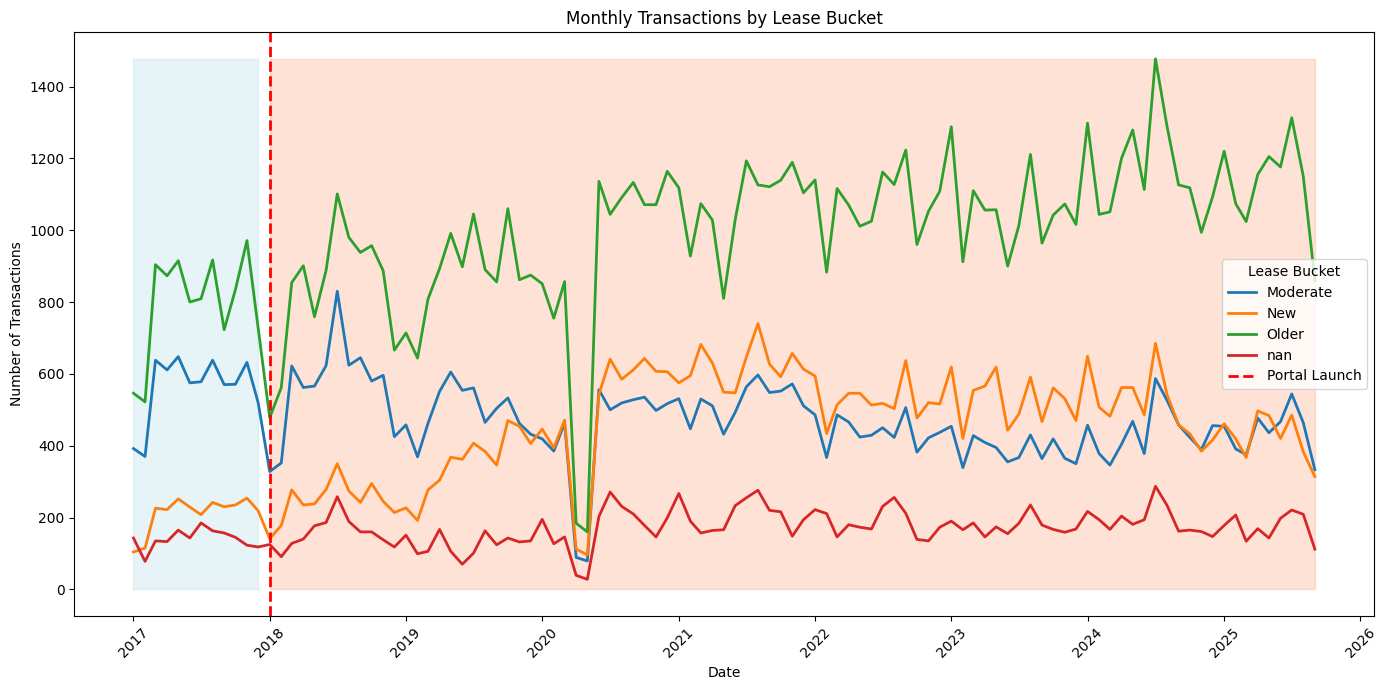

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

df_prices['date'] = pd.to_datetime(df_prices['month'])
df_prices['lease_bucket'] = df_prices['lease_bucket'].astype(str)

monthly_bucket = df_prices.groupby(['date', 'lease_bucket']).size().unstack(fill_value=0)
monthly_bucket = monthly_bucket.sort_index()

plt.figure(figsize=(14,7))
for bucket in monthly_bucket.columns:
    plt.plot(monthly_bucket.index, monthly_bucket[bucket], linewidth=2, label=bucket)

portal_launch = pd.to_datetime('2018-01-01')
plt.axvline(portal_launch, color='red', linestyle='--', linewidth=2, label='Portal Launch')

plt.fill_between(monthly_bucket.index, 0, monthly_bucket.max().max(), where=monthly_bucket.index<portal_launch, color='lightblue', alpha=0.3)
plt.fill_between(monthly_bucket.index, 0, monthly_bucket.max().max(), where=monthly_bucket.index>=portal_launch, color='lightsalmon', alpha=0.3)

plt.title('Monthly Transactions by Lease Bucket')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Lease Bucket')
plt.tight_layout()
plt.show()


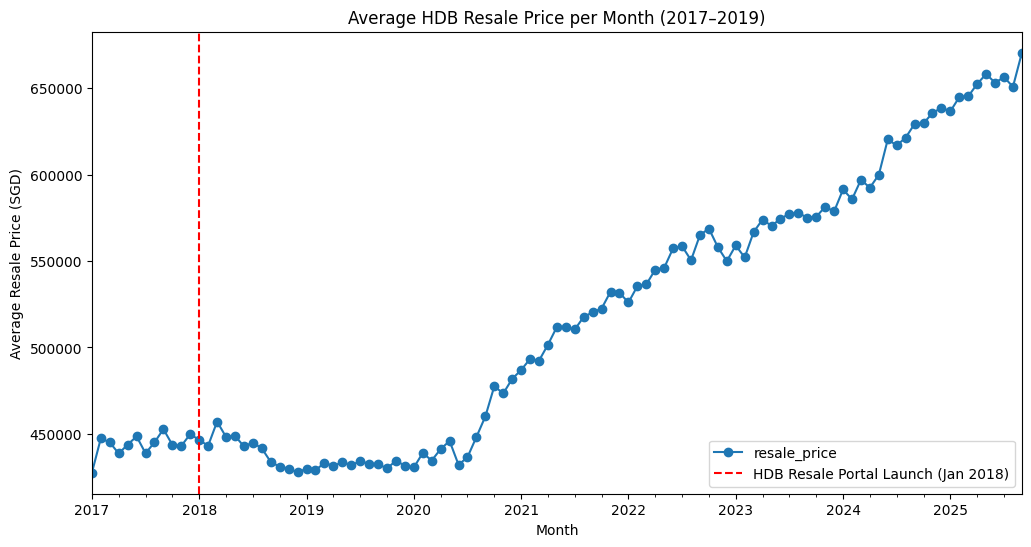

In [20]:
monthly_avg_price = df_prices.groupby("month")["resale_price"].mean()
monthly_avg_price.plot(marker="o", figsize=(12,6))
plt.axvline(cutoff, color="red", linestyle="--", label="HDB Resale Portal Launch (Jan 2018)")
plt.title("Average HDB Resale Price per Month (2017–2019)")
plt.xlabel("Month")
plt.ylabel("Average Resale Price (SGD)")
plt.legend()
plt.show()


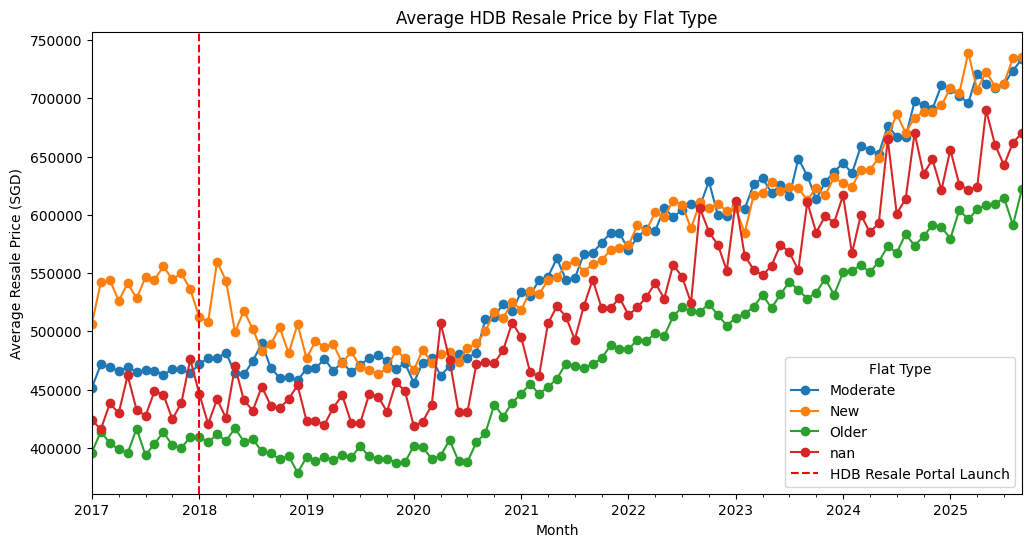

In [21]:
monthly_avg_by_type = df_prices.groupby(["month","lease_bucket"])["resale_price"].mean().unstack()
monthly_avg_by_type.plot(marker="o", figsize=(12,6))
plt.axvline(cutoff, color="red", linestyle="--", label="HDB Resale Portal Launch")
plt.title("Average HDB Resale Price by Flat Type")
plt.xlabel("Month")
plt.ylabel("Average Resale Price (SGD)")
plt.legend(title="Flat Type")
plt.show()


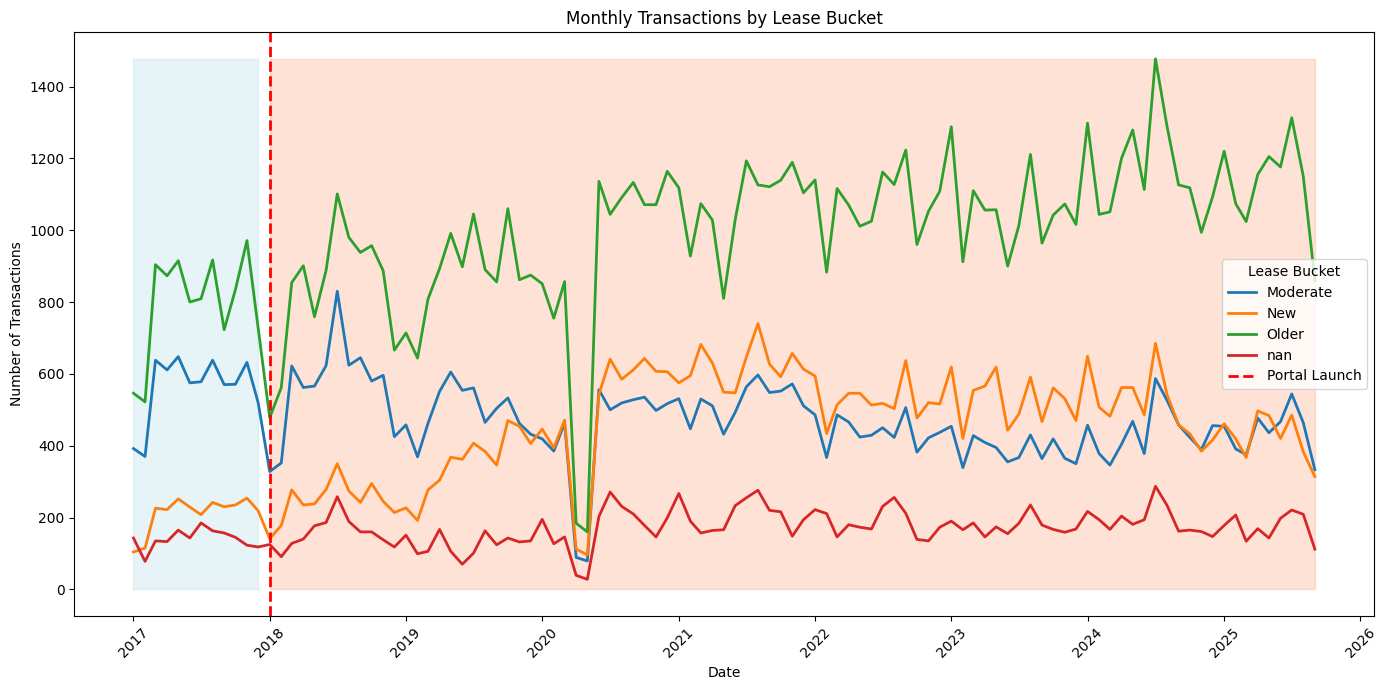

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df_prices['date'] = pd.to_datetime(df_prices['month'])
df_prices['lease_bucket'] = df_prices['lease_bucket'].astype(str)

monthly_bucket = df_prices.groupby(['date', 'lease_bucket']).size().unstack(fill_value=0)
monthly_bucket = monthly_bucket.sort_index()

plt.figure(figsize=(14,7))
for bucket in monthly_bucket.columns:
    plt.plot(monthly_bucket.index, monthly_bucket[bucket], linewidth=2, label=bucket)

portal_launch = pd.to_datetime('2018-01-01')
plt.axvline(portal_launch, color='red', linestyle='--', linewidth=2, label='Portal Launch')

plt.fill_between(monthly_bucket.index, 0, monthly_bucket.max().max(), where=monthly_bucket.index<portal_launch, color='lightblue', alpha=0.3)
plt.fill_between(monthly_bucket.index, 0, monthly_bucket.max().max(), where=monthly_bucket.index>=portal_launch, color='lightsalmon', alpha=0.3)

plt.title('Monthly Transactions by Lease Bucket')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Lease Bucket')
plt.tight_layout()
plt.show()
